In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass

## Create Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
def create_example(x,y):
  c = np.random.randint(0, 2)
  image = 0.5 * np.random.rand(28, 28, 3)
  image[:, :, c] += 0.5 * x / 255.
  return image, y, c

digit:0, color: red


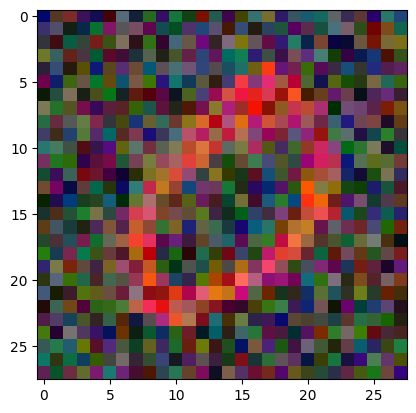

In [5]:
colors = {0: 'red', 1: 'green'}

x, y, c = create_example(x_train[1], y_train[1])
print(f'digit:{y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

## Dataset Generator

In [6]:
def generate_data(x, y, batch_size = 32):
  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 28, 28,3))
    y_batch = np.zeros((batch_size,))
    c_batch = np.zeros((batch_size,))

    for i in range(0, batch_size):
      index = np.random.randint(0, num_examples)
      image, digit, color = create_example(x[index], y[index])
      x_batch[i] = image
      y_batch[i] = digit
      c_batch[i] = color

    yield x_batch, [y_batch, c_batch]
     

In [8]:
x, [y, c] = next(generate_data(x_test, y_test, batch_size = 1))

[5.] [1.]


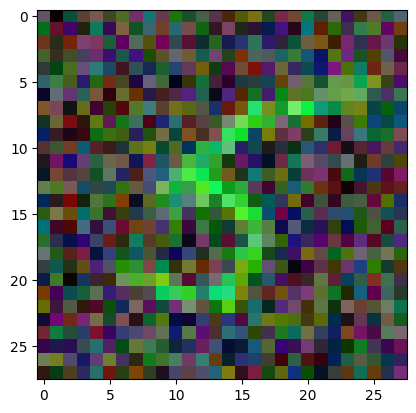

In [9]:
print(y, c)
plt.imshow(x[0])

## Create Model

In [10]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense
input_ = Input(shape = (28, 28, 3), name = 'input')
conv_1 = Conv2D(32, 3, name = 'conv_1')(input_)
act_1 = Activation('relu', name = 'act_1')(conv_1)

pool_1 = MaxPool2D(4, name = 'pool_1')(act_1)
flat_1 = Flatten(name = 'flat_1')(pool_1)

color = Dense(1, activation = 'sigmoid', name = 'color')(flat_1)

conv_2 = Conv2D(32, 3, padding = 'same', name = 'conv_2')(act_1)
act_2 = Activation('relu', name = 'act_2')(conv_2)

conv_3 = Conv2D(32, 3, padding = 'same', name = 'conv_3')(act_2)
add = Add(name = 'add')([act_1, conv_3])
act_3 = Activation('relu', name = 'act_3')(add)

pool_2 = MaxPool2D(4, name = 'pool_2')(act_3)
flat_2 = Flatten(name = 'flat_2')(pool_2)

digit = Dense(10, activation = 'softmax', name = 'digit')(flat_2)

model = tf.keras.models.Model(input_, [digit, color])

model.compile(
    loss = {
        'digit': 'sparse_categorical_crossentropy',
        'color': 'binary_crossentropy'
    },
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 26, 26, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
act_1 (Activation)              (None, 26, 26, 32)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 26, 26, 32)   9248        act_1[0][0]                      
______________________________________________________________________________________________

In [11]:
tf.keras.utils.plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Training the Model

In [12]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [13]:
train_gen = generate_data(x_train, y_train)
test_gen = generate_data(x_test, y_test)
_ = model.fit(
      train_gen,
      validation_data = test_gen,
      steps_per_epoch = 200,
      validation_steps = 100,
      epochs = 10,
      callbacks = [
          Logger(),
          tf.keras.callbacks.TensorBoard(log_dir = './logs')
      ],
      verbose = False
  )

============================== 1 ==============================
digit_accuracy: 0.58, color_accuracy: 0.95
val_digit_accuracy: 0.85, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.88, color_accuracy: 1.00
val_digit_accuracy: 0.92, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.93, color_accuracy: 1.00
val_digit_accuracy: 0.95, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.95, color_accuracy: 1.00
val_digit_accuracy: 0.95, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.96, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.96, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 7 ===================

## Final Predictions

In [14]:
def test_model(show=True):
  x, [y, c] = next(test)
  
  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])
  
  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
GT: 7, red
Pr: 2, green


C:\Users\HP\AppData\Local\Temp\ipykernel_11128\754892560.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_color = int(preds[1] > 0.5)


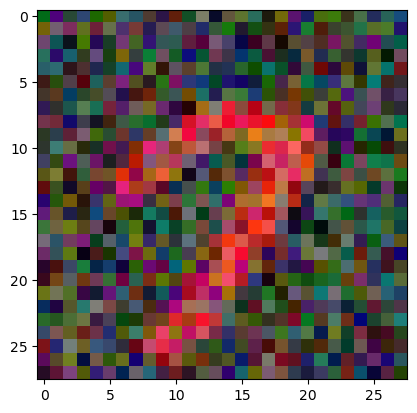

In [16]:
test_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


C:\Users\HP\AppData\Local\Temp\ipykernel_11128\754892560.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_color = int(preds[1] > 0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


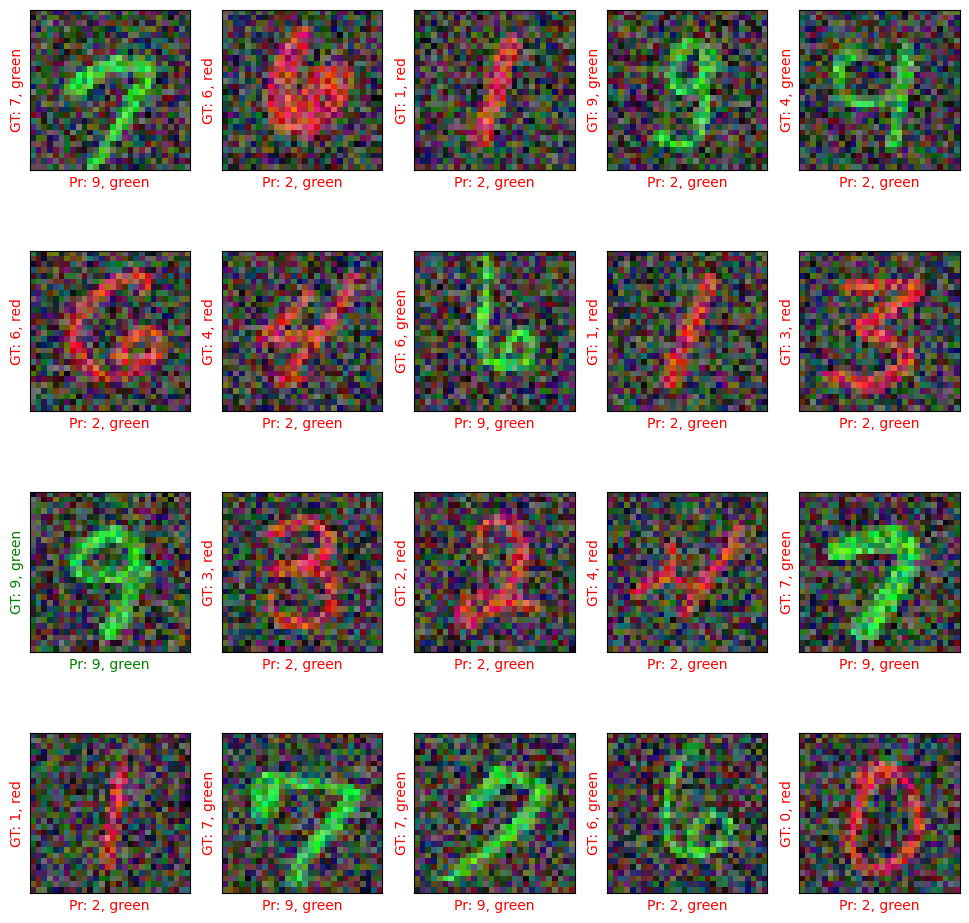

In [15]:
plt.figure(figsize = (12, 12))
for i in range(0, 20):
  plt.subplot(4, 5, i + 1)
  test_model(show = False)
plt.show()